[View in Colaboratory](https://colab.research.google.com/github/gonzalezf/Tarea3-INF395/blob/master/Tarea_3_1_2_Adam_con_lr_=_0_0001.ipynb)

In [0]:
from keras.layers import Input,Conv2D,Flatten,Dense,MaxPool2D
from keras.models import Model
from keras.datasets import mnist
import numpy as np
import keras
from keras.layers import Reshape,Conv2DTranspose,Activation
from keras import backend as K
from keras.layers import Lambda
from keras import utils
import matplotlib.pyplot as plt
from keras.models import load_model
from scipy.stats import norm
from keras.layers import Dropout

In [4]:

(X_train, y_train), (X_test, y_test) = mnist.load_data()


11493376/11490434 [==============================] - 1s 0us/step


In [0]:
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255


In [0]:
X_train = X_train.reshape(X_train.shape[0], 28, 28, 1)
X_test = X_test.reshape(X_test.shape[0], 28, 28, 1)

In [0]:
img_rows, img_cols, channel = X_train.shape[1:]
# color channels (1 = grayscale, 3 = RGB) 
#si fueran imagenes a color, se utilizaria channel = 3

# GAN

In [0]:
from keras.models import Model,Sequential
from keras.layers import LeakyReLU,Conv2D,Dropout,Flatten,Dense
from keras.layers import BatchNormalization,Reshape,UpSampling2D,Conv2DTranspose,Activation
from keras.optimizers import RMSprop
from keras.models import Model,Sequential
from keras.layers import LeakyReLU,Conv2D,Dropout,Flatten,Dense

In [9]:


## Discriminator
D = Sequential()
depth = 64
dropout = 0.4
input_shape = (img_rows, img_cols, channel)
D.add(Conv2D(depth*1, (5,5), strides=2, input_shape=input_shape,padding='same', activation=LeakyReLU(alpha=0.2)))
D.add(Dropout(dropout))
D.add(Conv2D(depth*2, (5,5), strides=2, padding='same',activation=LeakyReLU(alpha=0.2)))
D.add(Dropout(dropout))
D.add(Conv2D(depth*4, (5,5), strides=2, padding='same',activation=LeakyReLU(alpha=0.2)))
D.add(Dropout(dropout))
D.add(Flatten())
D.add(Dense(1024,activation=LeakyReLU(alpha=0.2)))
D.add(Dense(1,activation='sigmoid'))
D.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 14, 14, 64)        1664      
_________________________________________________________________
dropout_1 (Dropout)          (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 128)         204928    
_________________________________________________________________
dropout_2 (Dropout)          (None, 7, 7, 128)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 4, 4, 256)         819456    
_________________________________________________________________
dropout_3 (Dropout)          (None, 4, 4, 256)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 4096)              0         
__________

/usr/local/lib/python3.6/dist-packages/keras/activations.py:115: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))


In [10]:

from keras.layers import BatchNormalization,Reshape,UpSampling2D,Conv2DTranspose,Activation
## Generator
G = Sequential()
dim = 14
input_dim= 2 #para que sea similar al vAE
G.add(Dense(128, input_dim=input_dim))
G.add(BatchNormalization())
G.add(Activation('relu'))
G.add(Dense(dim*dim*depth))
G.add(BatchNormalization())
G.add(Activation('relu'))
G.add(Reshape((dim, dim, depth)))
G.add(Conv2DTranspose(int(depth/2), (3,3), padding='same',strides=(2,2)))
G.add(BatchNormalization())
G.add(Activation('relu'))
G.add(Conv2DTranspose(int(depth/2), (3,3), padding='same'))
G.add(BatchNormalization())
G.add(Activation('relu'))
G.add(Conv2DTranspose(channel, (3,3), padding='same')) 
G.add(Activation('sigmoid')) 
G.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 128)               384       
_________________________________________________________________
batch_normalization_1 (Batch (None, 128)               512       
_________________________________________________________________
activation_1 (Activation)    (None, 128)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 12544)             1618176   
_________________________________________________________________
batch_normalization_2 (Batch (None, 12544)             50176     
_________________________________________________________________
activation_2 (Activation)    (None, 12544)             0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 14, 14, 64)        0         
__________

In [0]:

from keras.optimizers import RMSprop
from keras.optimizers import Adam

## Discriminator model (police)
#optimizer = RMSprop(lr=0.0008, clipvalue=1.0, decay=6e-8)
optimizer = Adam(0.001)
DM = Sequential()
DM.add(D)
DM.compile(loss='binary_crossentropy', optimizer=optimizer,metrics=['accuracy'])
## Adversarial model (Generator->Discriminator)
D.trainable=False #set the discriminator freeze  (fixed params)
#optimizer = RMSprop(lr=0.0004, clipvalue=1.0, decay=3e-8)
optimizer = Adam(lr = 0.0001)
AM = Sequential()
AM.add(G)
AM.add(D)
AM.compile(loss='binary_crossentropy', optimizer=optimizer,metrics=['accuracy'])


In [12]:

def train_on_steps(X_train,DM,AM,G,steps,batch_size):
    history = {"d":[],"g":[]}
    for e in range(train_steps):
        # Make generative images
        image_batch = X_train[np.random.randint(0,X_train.shape[0],size=batch_size),:,:,:] #sample images from real data
        noise_gen = np.random.uniform(-1,1,size=[batch_size,input_dim]) #sample image from generated data
        generated_images = G.predict(noise_gen) #fake images
        # Train discriminator on generated images
        X = np.concatenate((image_batch, generated_images))
        #create labels
        y = np.ones([2*batch_size,1])
        y[batch_size:,:] = 0
        d_loss  = DM.train_on_batch(X,y)
        history["d"].append(d_loss)
        # train Generator-Discriminator stack on input noise to non-generated output class
        noise_tr = np.random.uniform(-1,1,size=[batch_size,input_dim])
        y = np.ones([batch_size, 1])
        g_loss = AM.train_on_batch(noise_tr, y)
        history["g"].append(g_loss)
        log_mesg = "%d: [D loss: %f, acc: %f]" % (e, d_loss[0], d_loss[1])
        log_mesg = "%s  [G loss: %f, acc: %f]" % (log_mesg, g_loss[0], g_loss[1])
        print(log_mesg)
    return history
train_steps = 5000 #or few if  you want
hist = train_on_steps(X_train,DM,AM,G,train_steps,64)

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:975: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


0: [D loss: 0.686838, acc: 0.671875]  [G loss: 1.384352, acc: 0.000000]
1: [D loss: 0.518227, acc: 0.570312]  [G loss: 3.843259, acc: 0.000000]
2: [D loss: 0.280287, acc: 0.953125]  [G loss: 0.094210, acc: 1.000000]
3: [D loss: 1.417555, acc: 0.500000]  [G loss: 8.325933, acc: 0.000000]
4: [D loss: 0.144066, acc: 0.960938]  [G loss: 12.545464, acc: 0.000000]
5: [D loss: 0.475059, acc: 0.757812]  [G loss: 11.654345, acc: 0.000000]
6: [D loss: 0.401079, acc: 0.765625]  [G loss: 8.609407, acc: 0.000000]
7: [D loss: 0.190151, acc: 0.929688]  [G loss: 5.636868, acc: 0.000000]
8: [D loss: 0.076134, acc: 0.984375]  [G loss: 3.023290, acc: 0.000000]
9: [D loss: 0.053312, acc: 1.000000]  [G loss: 1.841708, acc: 0.000000]
10: [D loss: 0.152195, acc: 0.953125]  [G loss: 2.516591, acc: 0.000000]
11: [D loss: 0.097051, acc: 0.984375]  [G loss: 4.352693, acc: 0.000000]
12: [D loss: 0.020598, acc: 1.000000]  [G loss: 5.919382, acc: 0.000000]
13: [D loss: 0.005941, acc: 1.000000]  [G loss: 7.761530, a

In [0]:
loss_discriminador = [] 
acc_discriminador = [] 
loss_generador = []
acc_generador = []

for loss, acc in hist['d']:
  loss_discriminador.append(loss)
  acc_discriminador.append(acc)

for loss, acc in hist['g']:
  loss_generador.append(loss)
  acc_generador.append(acc)

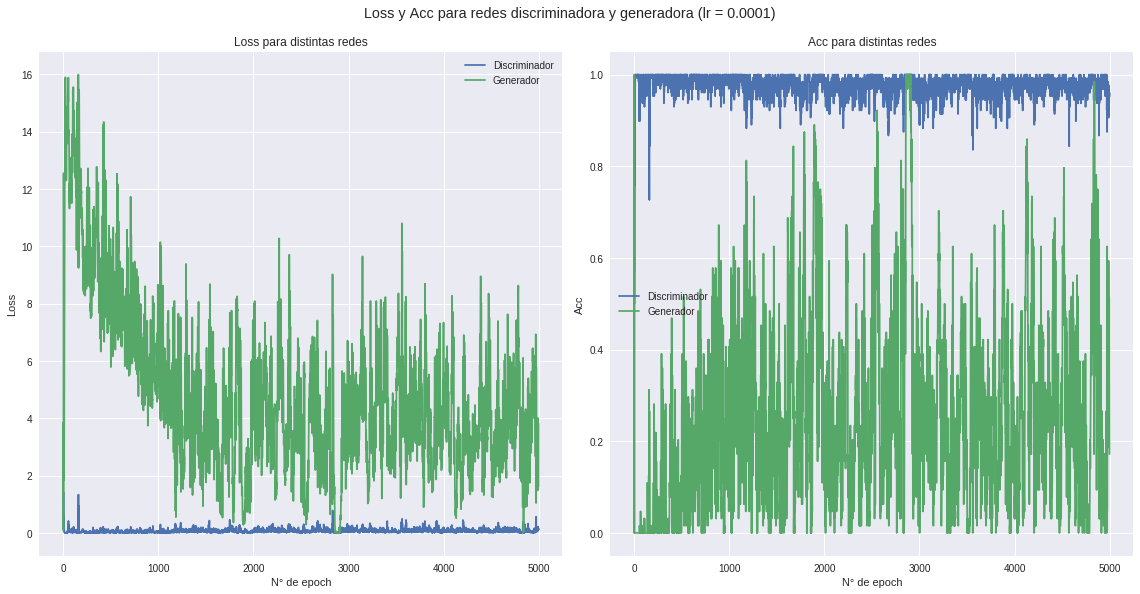

In [16]:
plt.figure(6, figsize=(16,8))
plt.suptitle("Loss y Acc para redes discriminadora y generadora (lr = 0.0001)", y=1.03)
plt.subplot(121)
plt.title("Loss para distintas redes")
plt.plot(loss_discriminador, label = "Discriminador")
plt.plot(loss_generador, label="Generador")
plt.ylabel("Loss")
plt.xlabel("N° de epoch")
plt.legend()
plt.tight_layout()
plt.subplot(122)
plt.title("Acc para distintas redes")
plt.plot(acc_discriminador, label = "Discriminador")
plt.plot(acc_generador, label="Generador")
plt.ylabel("Acc")
plt.xlabel("N° de epoch")
plt.legend()
plt.tight_layout()
plt.show();

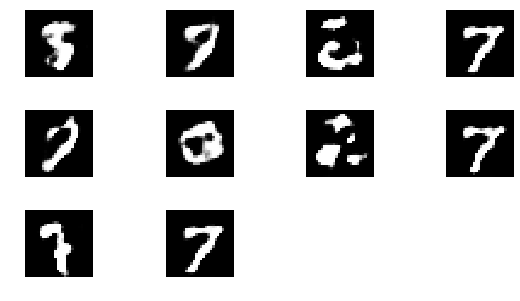

In [17]:
N = 10
noise = np.random.uniform(-1.0, 1.0, size=[N, input_dim]) 
images = G.predict(noise)
import matplotlib.pyplot as plt
for i in range(images.shape[0]):
    plt.subplot(4, 4, i+1)
    image = images[i, :, :, :]
    image = np.reshape(image, [img_rows, img_cols])
    plt.imshow(image, cmap='gray')
    plt.axis('off')
plt.tight_layout()
plt.show()